## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import lightgbm as lgb
import xgboost as xgb
# import timeb
from collections import Counter
import datetime
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from sklearn import metrics
from typing import Any
from itertools import product
import re
from tqdm import tqdm
from joblib import Parallel, delayed

random_seed = 33

Using TensorFlow backend.


In [2]:
# train = pd.read_csv('../data/preprocess/train895.csv')
# test = pd.read_csv('../data/preprocess/test895.csv')
# # train = pd.read_csv('../data/preprocess/train_1225.csv')
# # test = pd.read_csv('../data/preprocess/test_1225.csv')
# train = pd.read_csv('../data/preprocess/train_1225_2.csv')
# test = pd.read_csv('../data/preprocess/test_1225_2.csv')

# train = pd.read_csv('../data/preprocess/train_0102_filter.csv')
# test = pd.read_csv('../data/preprocess/test_0102_filter.csv')
# train = pd.read_csv('../data/preprocess/train_0102_filter_reset3.csv')
# test = pd.read_csv('../data/preprocess/test_0102_filter_reset3.csv')


train = pd.read_csv('../data/preprocess/train_0106.csv')
test = pd.read_csv('../data/preprocess/test_0106.csv')

## Helper function

In [3]:
def cut_pred(pr1: np.array, coef: list):
    assert len(coef)==3
    pr1[pr1 <= coef[0]] = 0
    pr1[np.where(np.logical_and(pr1 > coef[0], pr1 <= coef[1]))] = 1
    pr1[np.where(np.logical_and(pr1 > coef[1], pr1 <= coef[2]))] = 2
    pr1[pr1 > coef[2]] = 3
    
    return pr1

## custom eval_metrics

In [4]:
from sklearn.metrics import cohen_kappa_score

## https://github.com/catboost/tutorials/blob/master/custom_loss/custom_loss_and_metric_tutorial.ipynb
class qwk(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is list of indexed containers
        # (containers with only __len__ and __getitem__ defined), one container
        # per approx dimension. Each container contains floats.
        # weight is one dimensional indexed container.
        # target is float.   
        # weight parameter can be None.
        # Returns pair (error, weights sum)

        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 1.0
        y_true = []
        y_pred = []
        for i in range(len(approx)):
            y_true.append(target[i])
            y_pred.append(approx[i])
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        
        y_pred[y_pred <= 0.54535191] = 0
        y_pred[np.where(np.logical_and(y_pred > 0.54535191, y_pred <= 1.61037589))] = 1
        y_pred[np.where(np.logical_and(y_pred > 1.61037589, y_pred <= 2.23003452))] = 2
        y_pred[y_pred > 2.23003452] = 3
        
#         y_pred[y_pred <= 1.12232214] = 0
#         y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
#         y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
#         y_pred[y_pred > 2.22506454] = 3
        
        error_sum = cohen_kappa_score(y_true, y_pred,weights='quadratic')
#         error_sum = qwk(y_true, y_pred)
        
        return error_sum, weight_sum

@jit
def qwk_np(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred2 = y_pred.copy()
    y_pred2[y_pred2 <= 1.12232214] = 0
    y_pred2[np.where(np.logical_and(y_pred2 > 1.12232214, y_pred2 <= 1.73925866))] = 1
    y_pred2[np.where(np.logical_and(y_pred2 > 1.73925866, y_pred2 <= 2.22506454))] = 2
    y_pred2[y_pred2 > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'qwk', qwk_np(y_true, y_pred2), True

def eval_qwk_lgb_regr2(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred2 = y_pred.copy()
    y_pred2[y_pred2 <= 0.5] = 0
    y_pred2[np.where(np.logical_and(y_pred2 > 0.5, y_pred2 <= 1.5))] = 1
    y_pred2[np.where(np.logical_and(y_pred2 > 1.5, y_pred2 <= 2.5))] = 2
    y_pred2[y_pred2 > 2.5] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'qwk2', qwk_np(y_true, y_pred2), True

In [5]:
def find_col(df, cols):
    ## return the index of cols in df.columns, ignore if col not exit
    cols2 = []
    for c in cols:
        if c in df.columns:
            cols2.append(c)
    return cols2

In [6]:
## k-fold cv

cat_cols = ['title','world','timestamp_weekday']
drop_cols = ['installation_id', 'game_session', 'timestamp', 'accuracy_group']
cat_cols= find_col(train, cat_cols)
drop_cols = find_col(train, drop_cols)

y = train['accuracy_group']
X = train.drop(columns=drop_cols)

n_fold = 5
folds = GroupKFold(n_splits=n_fold)

for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, train['installation_id'])):
    pass


In [7]:
import eli5
from eli5.sklearn import PermutationImportance

## Wrapper
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None, permutation=False):
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
            del params['cat_cols']
        else:
            categorical_columns = 'auto'
        
#         eval_metric = lambda y_true, y_pred: [eval_qwk_lgb_regr(y_true, y_pred), eval_qwk_lgb_regr2(y_true, y_pred)]
        eval_metric = eval_qwk_lgb_regr

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_
        
        if permutation:
#             perm = PermutationImportance(self.model, random_state=self.random_seed).fit(X_valid, y_valid)
            perm = PermutationImportance(self.model).fit(X_valid, y_valid)
            self.feature_importances2_ = pd.DataFrame({'feature':X_valid.columns.tolist(),'importance':perm.feature_importances_})

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)


class CatboostWrapper_regr(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = CatBoostRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None, permutation=False):
        
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
            del params['cat_cols']
        else:
            categorical_columns = None

        eval_set = []
        eval_names = []
        self.model = self.model.set_params(**params)
        self.model = self.model.set_params(eval_metric=qwk())
        
        
        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')
        elif X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')
        else:
            eval_set.append((X_train, y_train))
            eval_names.append('train')

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.get_best_score()
        
        test_pool=Pool(X_valid, y_valid,cat_features=categorical_columns)
        self.feature_importances_ = self.model.get_feature_importance(test_pool,thread_count=4)

    def predict(self, X_test):
        return self.model.predict(X_test, ntree_end=self.model.get_best_iteration())


from sklearn.base import BaseEstimator, TransformerMixin
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):
#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [8]:
class RegressorModel(object):
    """
    A wrapper class for regression models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).
    """

    def __init__(self, columns: list=None, model_wrapper=None, random_state=33):
        """
        :param columns: columns to train
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.random_seed = random_state
        
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            X_append: pd.DataFrame = None, y_append: pd.DataFrame = None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True,
            permutation=False):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=self.random_seed)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        ## model FI and permutation FI
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.feature_importances_p = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]
        if X_append is not None:
            X_append = X_append[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
                
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = pd.concat([X.iloc[train_index],X_append],axis=0), X.iloc[valid_index]
            y_train, y_valid = pd.concat([y.iloc[train_index],y_append],axis=0), y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

#             if adversarial:
#                 X_new1 = X_train.copy()
#                 if X_valid is not None:
#                     X_new2 = X_valid.copy()
#                 elif X_holdout is not None:
#                     X_new2 = X_holdout.copy()
#                 X_new = pd.concat([X_new1, X_new2], axis=0)
#                 y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
#                 X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params.copy(), permutation=permutation)
            self.folds_dict[fold_n]['scores'] = model.best_score_
            
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            if permutation:
                fold_importance_p = pd.DataFrame(list(zip(X_train.columns, model.feature_importances2_)),
                                               columns=['feature', 'importance'])
                self.feature_importances_p = self.feature_importances.append(fold_importance_p)
            
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)
        if permutation:
            self.feature_importances_p['importance'] = self.feature_importances_p['importance'].astype(float)

        self.calc_scores_()
        
        if plot:
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')
        print(feature_importances.sort_values(by='importance'))

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10, fi_type=1):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        fi = self.feature_importances
        if fi_type=='p':
            fi = self.feature_importances_p
            
        grouped_feats = fi.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def get_top_features2(self, drop_null_importance: bool = True, top_n: int = 10, fi_type=1):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        fi = self.feature_importances
        if fi_type=='p':
            fi = self.feature_importances_p
            
        grouped_feats = fi.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return grouped_feats.sort_values(ascending=False).iloc[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')


In [9]:
lgb_params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 50,
            'early_stopping_rounds': 100, 
#             'eval_metric': lgb_kappa_eval,
#             'eval_metric': ['qwk','qwk2','qwk3']
            }

cat_params = {'iterations':2000,
            'loss_function': 'RMSE',
            'verbose': 50,
            'early_stopping_rounds': 100, 
#             'task_type':"GPU",
#             'devices':'0:1',
            }

para_tune = {'feature_fraction': 0.9985706623844444, 'lambda_l1': 1.3464702887971034, 'lambda_l2': 24.03486401669668, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.9982720526777418, 'subsample_freq': 2}
## 0.970
# para_tune = {'feature_fraction': 0.7208784814394442, 'lambda_l1': 1.0547998031340668, 'lambda_l2': 47.046761174073815, 'max_depth': 15, 'num_leaves': 39, 'subsample': 0.9658561677957942, 'subsample_freq': 1}

# for k in para_tune:
#     lgb_params[k] = para_tune[k]

In [10]:
train = train.fillna(-10)

Fold 1 started at Wed Jan  8 02:54:53 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.954421	train's qwk: 0.644732	valid's rmse: 0.988949	valid's qwk: 0.612426
[100]	train's rmse: 0.895847	train's qwk: 0.68766	valid's rmse: 0.971132	valid's qwk: 0.618009
[150]	train's rmse: 0.85861	train's qwk: 0.714382	valid's rmse: 0.967594	valid's qwk: 0.616311
[200]	train's rmse: 0.827603	train's qwk: 0.740264	valid's rmse: 0.967553	valid's qwk: 0.618473
[250]	train's rmse: 0.799509	train's qwk: 0.765378	valid's rmse: 0.965859	valid's qwk: 0.622685
[300]	train's rmse: 0.77383	train's qwk: 0.784906	valid's rmse: 0.9656	valid's qwk: 0.622741
[350]	train's rmse: 0.750137	train's qwk: 0.802037	valid's rmse: 0.965631	valid's qwk: 0.620919
[400]	train's rmse: 0.727767	train's qwk: 0.815841	valid's rmse: 0.967406	valid's qwk: 0.620343
Early stopping, best iteration is:
[320]	train's rmse: 0.764017	train's qwk: 0.791313	valid's rmse: 0.96527	valid's qwk: 0.623702
Fol

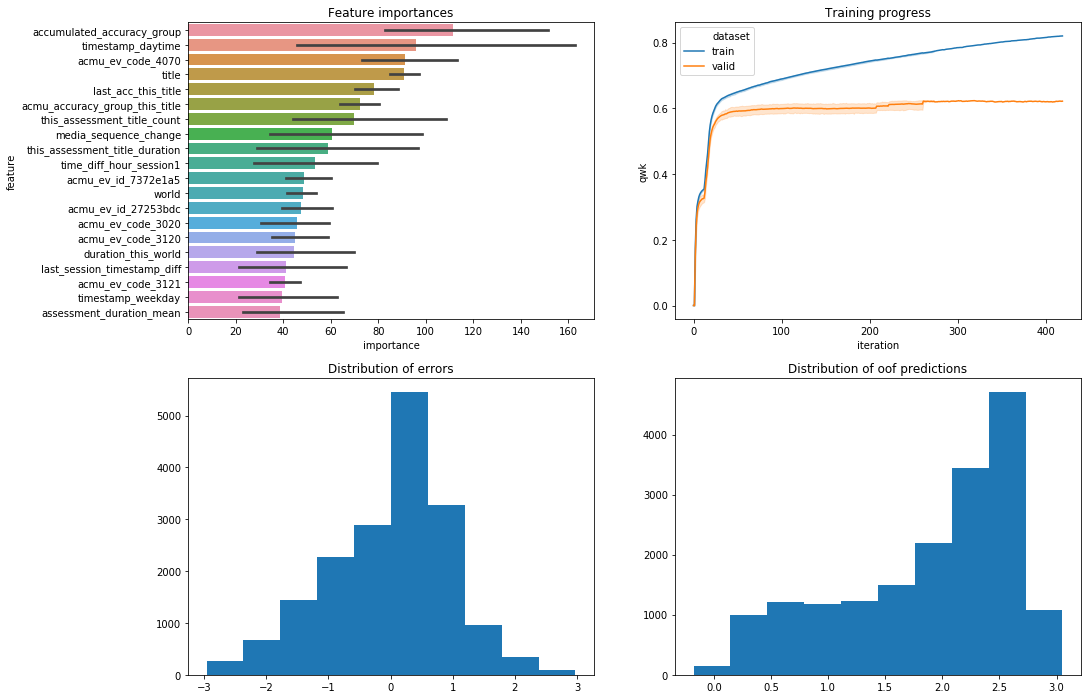

In [11]:
y = train['accuracy_group']
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

cat_cols = ['title','world','timestamp_weekday']
cols_to_drop = ['installation_id', 'game_session', 'timestamp', 'accuracy_group']
cat_params['cat_cols'] = cat_cols
lgb_params['cat_cols'] = cat_cols


mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=train, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)
# regressor_model1 = RegressorModel(model_wrapper=CatboostWrapper_regr())
# regressor_model1.fit(X=train, y=y, folds=folds, params=cat_params, preprocesser=mt, transformers=transformers,
#                     eval_metric='qwk', cols_to_drop=cols_to_drop)

## Feature Selection
* RFE

In [12]:
X = train.drop(columns=cols_to_drop)
col = X.columns[X.isnull().sum()>0]
X = X.drop(columns=col)

from sklearn.preprocessing import StandardScaler
X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)

X_default = train.loc[:,['installation_id','timestamp','timestamp_weekday','timestamp_daytime','game_session','world','title','type']]

In [13]:
## RFE
## https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
from sklearn.feature_selection import RFE

lgb_params_rfe = {'n_estimators':120,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 0,
            }

for i in range(150,400,50):
    print(i)
    estimator = lgb.LGBMRegressor().set_params(**lgb_params_rfe)
    selector = RFE(estimator, n_features_to_select=i, step=0.02)
    selector = selector.fit(X, y)
    X_new = X.iloc[:,selector.get_support()]
    X_new = pd.concat([X_new,X_default],axis=1)
    
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=X_new, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)

150
Fold 1 started at Wed Jan  8 03:16:52 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.956627	train's qwk: 0.642195	valid's rmse: 0.989118	valid's qwk: 0.610271
[100]	train's rmse: 0.900543	train's qwk: 0.683231	valid's rmse: 0.969027	valid's qwk: 0.62095
[150]	train's rmse: 0.864409	train's qwk: 0.709764	valid's rmse: 0.965666	valid's qwk: 0.626191
[200]	train's rmse: 0.83459	train's qwk: 0.73464	valid's rmse: 0.964227	valid's qwk: 0.626361
[250]	train's rmse: 0.80778	train's qwk: 0.756969	valid's rmse: 0.962545	valid's qwk: 0.628089
[300]	train's rmse: 0.783511	train's qwk: 0.775471	valid's rmse: 0.963327	valid's qwk: 0.626489
Early stopping, best iteration is:
[236]	train's rmse: 0.815064	train's qwk: 0.7515	valid's rmse: 0.962837	valid's qwk: 0.629885
Fold 2 started at Wed Jan  8 03:16:55 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.958018	train's qwk: 0.643448	valid's rmse: 0.993358	valid's qwk: 

Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.956565	train's qwk: 0.6441	valid's rmse: 0.994678	valid's qwk: 0.610423
[100]	train's rmse: 0.900306	train's qwk: 0.680903	valid's rmse: 0.972991	valid's qwk: 0.624545
[150]	train's rmse: 0.863977	train's qwk: 0.711034	valid's rmse: 0.96832	valid's qwk: 0.620281
Early stopping, best iteration is:
[94]	train's rmse: 0.905403	train's qwk: 0.676479	valid's rmse: 0.973379	valid's qwk: 0.626209
Fold 3 started at Wed Jan  8 03:20:03 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.955246	train's qwk: 0.648629	valid's rmse: 0.991664	valid's qwk: 0.577383
[100]	train's rmse: 0.898537	train's qwk: 0.682578	valid's rmse: 0.976755	valid's qwk: 0.579398
[150]	train's rmse: 0.86235	train's qwk: 0.715172	valid's rmse: 0.975517	valid's qwk: 0.588669
[200]	train's rmse: 0.831329	train's qwk: 0.740633	valid's rmse: 0.974337	valid's qwk: 0.590928
[250]	train's rmse: 0.803694	train's 

Fold 5 started at Wed Jan  8 03:23:07 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.944786	train's qwk: 0.655671	valid's rmse: 1.02513	valid's qwk: 0.57343
[100]	train's rmse: 0.886152	train's qwk: 0.6928	valid's rmse: 1.0102	valid's qwk: 0.579701
[150]	train's rmse: 0.848658	train's qwk: 0.721272	valid's rmse: 1.00932	valid's qwk: 0.575028
Early stopping, best iteration is:
[94]	train's rmse: 0.891238	train's qwk: 0.689579	valid's rmse: 1.01071	valid's qwk: 0.582005

CV mean score on train: 0.7199 +/- 0.0302 std.
CV mean score on valid: 0.6044 +/- 0.0194 std.


In [14]:
estimator = lgb.LGBMRegressor().set_params(**lgb_params_rfe)
selector = RFE(estimator, n_features_to_select=200, step=0.02)
selector = selector.fit(X, y)
select_col = X.columns[selector.get_support()] 
select_col = list(select_col.values)

Fold 1 started at Wed Jan  8 03:24:33 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.956297	train's qwk: 0.640142	valid's rmse: 0.986566	valid's qwk: 0.613416
[100]	train's rmse: 0.899843	train's qwk: 0.684779	valid's rmse: 0.968665	valid's qwk: 0.619664
[150]	train's rmse: 0.863587	train's qwk: 0.71172	valid's rmse: 0.966188	valid's qwk: 0.620715
[200]	train's rmse: 0.832796	train's qwk: 0.735006	valid's rmse: 0.964053	valid's qwk: 0.623423
[250]	train's rmse: 0.805771	train's qwk: 0.759771	valid's rmse: 0.964676	valid's qwk: 0.624783
[300]	train's rmse: 0.781014	train's qwk: 0.779456	valid's rmse: 0.964453	valid's qwk: 0.624708
[350]	train's rmse: 0.757744	train's qwk: 0.795082	valid's rmse: 0.964844	valid's qwk: 0.623646
Early stopping, best iteration is:
[277]	train's rmse: 0.792188	train's qwk: 0.770474	valid's rmse: 0.964194	valid's qwk: 0.627131
Fold 2 started at Wed Jan  8 03:24:36 2020
Training until validation scores don't improve for 

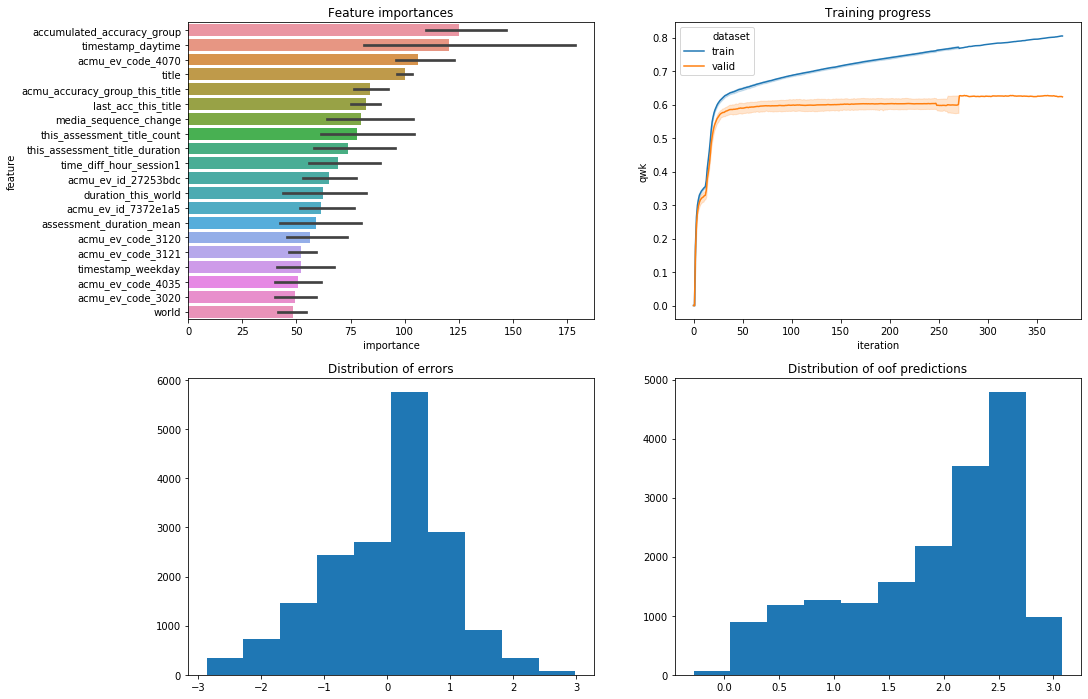

In [15]:
## feature selection
regressor_model2 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
regressor_model2.fit(X=train, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

Fold 1 started at Wed Jan  8 03:25:03 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.935347	train's qwk: 0.655525	valid's rmse: 0.983852	valid's qwk: 0.613819
[100]	train's rmse: 0.880496	train's qwk: 0.693175	valid's rmse: 0.967004	valid's qwk: 0.623716
[150]	train's rmse: 0.845481	train's qwk: 0.719462	valid's rmse: 0.962748	valid's qwk: 0.621063
Early stopping, best iteration is:
[87]	train's rmse: 0.89136	train's qwk: 0.685334	valid's rmse: 0.968938	valid's qwk: 0.624993
Fold 2 started at Wed Jan  8 03:25:05 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.936064	train's qwk: 0.657565	valid's rmse: 0.990889	valid's qwk: 0.614235
[100]	train's rmse: 0.881069	train's qwk: 0.691938	valid's rmse: 0.968662	valid's qwk: 0.625325
[150]	train's rmse: 0.847448	train's qwk: 0.71996	valid's rmse: 0.964418	valid's qwk: 0.62367
[200]	train's rmse: 0.81891	train's qwk: 0.742086	valid's rmse: 0.962784	valid's qwk: 0.6

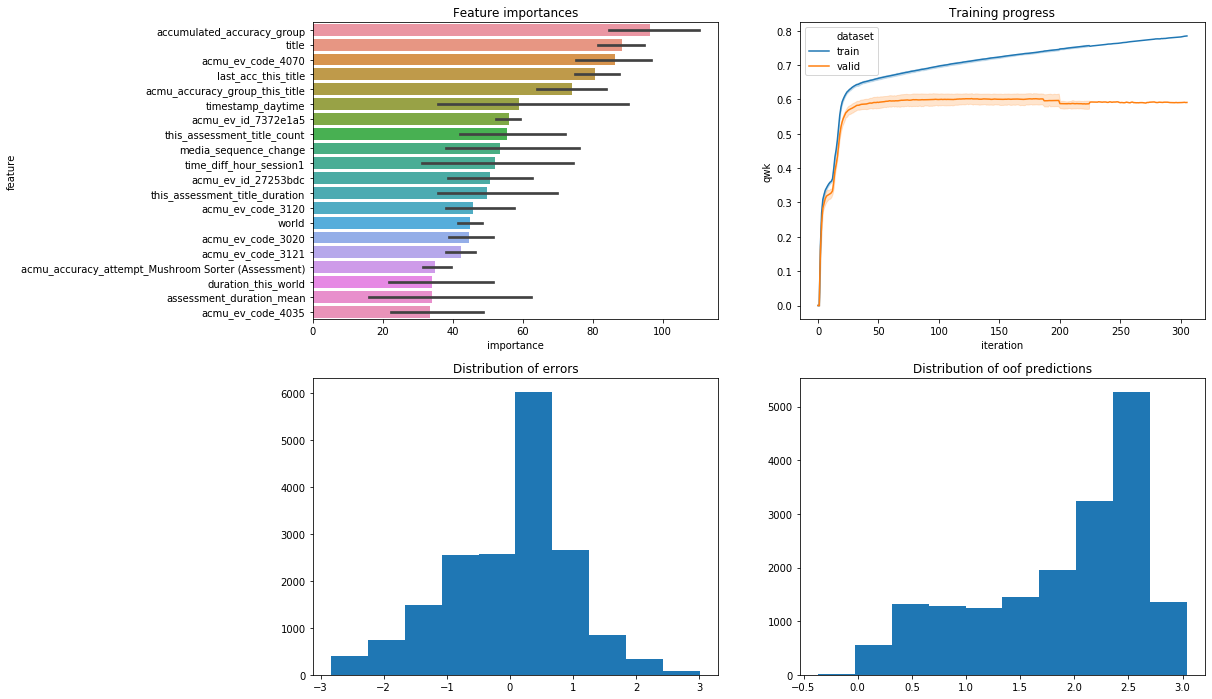

In [16]:
## semi-supervised learning
coef = [1.12232214,1.73925866,2.22506454]
y_test_pred = regressor_model1.predict(test)
y_test_pred = cut_pred(y_test_pred,coef)
X_append = test
y_append = pd.Series(y_test_pred.flatten())

regressor_model3 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
regressor_model3.fit(X=train, y=y, X_append=X_append, y_append=y_append, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

array([[2.18141064],
       [1.59727953],
       [2.48541607],
       ...,
       [2.03979474],
       [1.2109812 ],
       [1.8181089 ]])

In [17]:
## semi-supervised learning
## add train

coef = [1.12232214,1.73925866,2.22506454]
y_train_pseudo_pred = regressor_model2.predict(train_pseudo)
y_train_pseudo_pred = cut_pred(y_train_pseudo_pred,coef)
X_append = pd.concat([test,train_pseudo],axis=0)
y_append = pd.concat([pd.Series(y_test_pred.flatten()),pd.Series(y_train_pseudo_pred.flatten())]).reset_index(drop=True)

regressor_model4 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
regressor_model4.fit(X=train2, y=y2, X_append=X_append, y_append=y_append, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

NameError: name 'train_pseudo' is not defined

整理別人kernel中使用過的特徵

feature selection
* lasso?
* 相對訊息?

思考有哪些訓練方式:
有沒有比k-fold更好的?
semi-supervised learning? 將沒有assessment的使用者label加進訓練資料中
k-fold optimize th驗證結果

## Making predictions

The preprocessing is a class, which was initially written by Abhishek Thakur here: https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107 and later improved here https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved (the improvement is is speed).

It can be used to find optimal coefficients for thresholds. In this kernel I'll show an example, but when you do it, don't forget a proper validation.

In [ ]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk_np(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
#         self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='Powell')
        

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [ ]:
pr1 = regressor_model1.predict(train)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

In [ ]:
coefficients

In [ ]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk_np(y, opt_preds)

In [ ]:
pr1 = cut_pred(pr1,coef)

In [ ]:
coefficients

In [36]:
pred = pd.DataFrame(cut_pred(regressor_model3.oof,coef).flatten(),columns=['prediction'])

train2 = pd.concat([train,pred],axis=1)
train2['pred_diff'] = train2['accuracy_group']-train2['prediction']
cnt=0
for id, gp in train2.groupby(['installation_id']):
    cnt+=1
    if (cnt)>100:
        break
    print(id)
#     display(gp.iloc[:,-5:])
#     gp['title'] = gp['title'].map(activities_labels)
    display((gp.loc[:,['title','accuracy_group','prediction','pred_diff']]))

0006a69f


,title,accuracy_group,prediction,pred_diff
0,9,3,2.0,1.0
1,33,0,0.0,0.0
2,9,3,3.0,0.0
3,9,2,3.0,-1.0
4,33,3,0.0,3.0


0006c192


,title,accuracy_group,prediction,pred_diff
5,32,3,3.0,0.0
6,9,0,2.0,-2.0
7,33,2,0.0,2.0


00129856


,title,accuracy_group,prediction,pred_diff
8,33,3,0.0,3.0


001d0ed0


,title,accuracy_group,prediction,pred_diff
9,9,2,3.0,-1.0
10,9,3,3.0,0.0
11,33,0,0.0,0.0
12,7,3,3.0,0.0
13,8,0,0.0,0.0


00225f67


,title,accuracy_group,prediction,pred_diff
14,33,0,0.0,0.0


00279ac5


,title,accuracy_group,prediction,pred_diff
15,8,0,0.0,0.0


002db7e3


,title,accuracy_group,prediction,pred_diff
16,8,0,0.0,0.0
17,9,2,0.0,2.0
18,33,1,0.0,1.0
19,7,3,2.0,1.0
20,8,0,0.0,0.0
21,32,3,2.0,1.0
22,9,3,3.0,0.0
23,33,2,0.0,2.0
24,33,1,0.0,1.0


003372b0


,title,accuracy_group,prediction,pred_diff
25,9,3,3.0,0.0
26,33,2,2.0,0.0
27,7,3,3.0,0.0
28,7,3,3.0,0.0
29,8,0,0.0,0.0
30,32,3,3.0,0.0


004c2091


,title,accuracy_group,prediction,pred_diff
31,32,3,0.0,3.0
32,33,0,0.0,0.0
33,32,3,2.0,1.0
34,33,0,0.0,0.0


00634433


,title,accuracy_group,prediction,pred_diff
35,32,3,2.0,1.0
36,7,3,3.0,0.0
37,8,0,0.0,0.0


00667b88


,title,accuracy_group,prediction,pred_diff
38,7,3,0.0,3.0
39,7,0,2.0,-2.0


00691033


,title,accuracy_group,prediction,pred_diff
40,33,0,0.0,0.0
41,32,1,2.0,-1.0
42,33,0,0.0,0.0
43,8,0,0.0,0.0
44,32,3,2.0,1.0
45,33,1,0.0,1.0
46,9,0,2.0,-2.0
47,9,0,2.0,-2.0
48,33,0,0.0,0.0


00a0dbeb


,title,accuracy_group,prediction,pred_diff
49,7,0,0.0,0.0
50,7,0,0.0,0.0
51,7,0,0.0,0.0
52,7,0,0.0,0.0


00a53963


,title,accuracy_group,prediction,pred_diff
53,9,3,2.0,1.0


00ad158e


,title,accuracy_group,prediction,pred_diff
54,32,1,2.0,-1.0


00b9d8e6


,title,accuracy_group,prediction,pred_diff
55,7,2,3.0,-1.0


00cef781


,title,accuracy_group,prediction,pred_diff
56,7,3,3.0,0.0


00e17272


,title,accuracy_group,prediction,pred_diff
57,32,3,3.0,0.0
58,32,3,3.0,0.0
59,9,3,3.0,0.0
60,33,2,2.0,0.0
61,32,3,3.0,0.0
62,7,3,3.0,0.0
63,8,2,0.0,2.0
64,7,3,3.0,0.0


00e536bf


,title,accuracy_group,prediction,pred_diff
65,8,3,0.0,3.0
66,32,2,3.0,-1.0
67,7,3,3.0,0.0
68,8,0,0.0,0.0
69,33,1,0.0,1.0
70,32,3,3.0,0.0
71,7,3,3.0,0.0
72,8,3,0.0,3.0


00fa8681


,title,accuracy_group,prediction,pred_diff
73,8,0,0.0,0.0
74,9,3,0.0,3.0
75,33,1,0.0,1.0


00fc65b6


,title,accuracy_group,prediction,pred_diff
76,7,3,3.0,0.0
77,32,2,3.0,-1.0
78,9,3,3.0,0.0
79,33,3,0.0,3.0
80,7,1,3.0,-2.0
81,8,3,0.0,3.0
82,7,3,3.0,0.0
83,8,1,2.0,-1.0
84,32,3,3.0,0.0


010bc1d5


,title,accuracy_group,prediction,pred_diff
85,9,3,3.0,0.0
86,33,0,2.0,-2.0


01120f12


,title,accuracy_group,prediction,pred_diff
87,33,0,0.0,0.0


0153c957


,title,accuracy_group,prediction,pred_diff
88,33,0,0.0,0.0


0155dd86


,title,accuracy_group,prediction,pred_diff
89,7,3,2.0,1.0
90,8,0,0.0,0.0
91,8,0,0.0,0.0
92,7,3,2.0,1.0
93,8,0,0.0,0.0


015776b4


,title,accuracy_group,prediction,pred_diff
94,7,3,0.0,3.0
95,7,3,2.0,1.0
96,8,0,0.0,0.0
97,9,0,2.0,-2.0
98,8,0,0.0,0.0


01582211


,title,accuracy_group,prediction,pred_diff
99,7,2,3.0,-1.0
100,8,0,0.0,0.0
101,7,3,3.0,0.0
102,8,0,0.0,0.0
103,32,3,3.0,0.0


0160e7c5


,title,accuracy_group,prediction,pred_diff
104,7,1,3.0,-2.0


01825124


,title,accuracy_group,prediction,pred_diff
105,33,1,0.0,1.0
106,33,3,2.0,1.0
107,9,1,3.0,-2.0


01bdd720


,title,accuracy_group,prediction,pred_diff
108,7,3,3.0,0.0
109,8,0,0.0,0.0
110,9,3,3.0,0.0
111,33,3,0.0,3.0
112,7,3,3.0,0.0


01cc53f3


,title,accuracy_group,prediction,pred_diff
113,7,3,3.0,0.0
114,7,3,3.0,0.0
115,8,3,0.0,3.0
116,32,3,3.0,0.0


01d5e1f5


,title,accuracy_group,prediction,pred_diff
117,33,0,0.0,0.0


01f71702


,title,accuracy_group,prediction,pred_diff
118,9,3,3.0,0.0
119,33,3,2.0,1.0
120,7,3,3.0,0.0
121,8,0,0.0,0.0
122,33,2,2.0,0.0
123,32,2,3.0,-1.0


01faa4bf


,title,accuracy_group,prediction,pred_diff
124,7,3,3.0,0.0
125,8,2,0.0,2.0
126,9,3,3.0,0.0
127,33,3,2.0,1.0


022183ab


,title,accuracy_group,prediction,pred_diff
128,7,0,2.0,-2.0
129,9,3,0.0,3.0
130,7,0,2.0,-2.0
131,8,0,0.0,0.0
132,9,0,2.0,-2.0
133,33,0,0.0,0.0
134,32,0,0.0,0.0
135,9,1,0.0,1.0
136,33,0,0.0,0.0
137,7,3,0.0,3.0


0235fe9a


,title,accuracy_group,prediction,pred_diff
142,32,2,3.0,-1.0
143,7,3,3.0,0.0
144,8,0,0.0,0.0
145,9,0,3.0,-3.0
146,32,2,3.0,-1.0


023c4bcb


,title,accuracy_group,prediction,pred_diff
147,9,3,3.0,0.0
148,9,3,3.0,0.0


02490b06


,title,accuracy_group,prediction,pred_diff
149,8,1,0.0,1.0


026035e9


,title,accuracy_group,prediction,pred_diff
150,8,3,0.0,3.0
151,9,3,3.0,0.0
152,32,0,3.0,-3.0


026e3733


,title,accuracy_group,prediction,pred_diff
153,9,3,3.0,0.0


027b3c4c


,title,accuracy_group,prediction,pred_diff
154,32,3,3.0,0.0
155,7,3,3.0,0.0
156,8,3,0.0,3.0


0281f6bf


,title,accuracy_group,prediction,pred_diff
157,32,3,2.0,1.0
158,32,3,3.0,0.0
159,8,0,0.0,0.0
160,9,2,3.0,-1.0
161,33,0,0.0,0.0
162,7,3,3.0,0.0


02875dc2


,title,accuracy_group,prediction,pred_diff
163,7,3,3.0,0.0
164,7,3,3.0,0.0


0293ae74


,title,accuracy_group,prediction,pred_diff
165,9,2,0.0,2.0
166,33,1,0.0,1.0
167,7,3,3.0,0.0
168,9,2,3.0,-1.0


02aa515f


,title,accuracy_group,prediction,pred_diff
169,7,3,2.0,1.0
170,8,0,0.0,0.0
171,32,2,3.0,-1.0
172,33,1,0.0,1.0
173,7,0,3.0,-3.0


02b1fab4


,title,accuracy_group,prediction,pred_diff
174,9,3,3.0,0.0
175,33,3,2.0,1.0
176,7,3,3.0,0.0
177,8,3,2.0,1.0
178,32,3,3.0,0.0
179,7,3,3.0,0.0
180,8,3,2.0,1.0
181,9,3,3.0,0.0
182,33,3,3.0,0.0


02c975bc


,title,accuracy_group,prediction,pred_diff
183,7,1,0.0,1.0
184,32,2,0.0,2.0
185,9,3,0.0,3.0
186,33,0,0.0,0.0
187,33,3,0.0,3.0
188,7,3,3.0,0.0
189,8,2,0.0,2.0
190,7,3,3.0,0.0
191,32,3,3.0,0.0
192,33,2,2.0,0.0


02cdd48e


,title,accuracy_group,prediction,pred_diff
201,9,3,3.0,0.0
202,33,3,2.0,1.0
203,32,3,3.0,0.0
204,7,3,3.0,0.0


02cdfffd


,title,accuracy_group,prediction,pred_diff
205,9,0,3.0,-3.0
206,33,0,0.0,0.0
207,7,3,2.0,1.0
208,8,0,0.0,0.0
209,32,1,2.0,-1.0
210,9,2,0.0,2.0
211,33,0,0.0,0.0
212,9,1,2.0,-1.0
213,33,2,0.0,2.0


02e76f43


,title,accuracy_group,prediction,pred_diff
214,32,1,3.0,-2.0
215,32,3,3.0,0.0
216,32,3,3.0,0.0


031af3b8


,title,accuracy_group,prediction,pred_diff
217,7,3,2.0,1.0
218,8,0,0.0,0.0
219,32,2,2.0,0.0
220,33,0,0.0,0.0
221,7,3,3.0,0.0


0328fc8f


,title,accuracy_group,prediction,pred_diff
222,9,1,3.0,-2.0
223,7,0,0.0,0.0
224,8,3,0.0,3.0
225,9,0,2.0,-2.0
226,32,3,2.0,1.0
227,7,0,2.0,-2.0
228,8,0,0.0,0.0
229,9,1,2.0,-1.0
230,33,1,0.0,1.0
231,32,3,3.0,0.0


03401e19


,title,accuracy_group,prediction,pred_diff
234,32,3,3.0,0.0
235,9,3,3.0,0.0
236,9,3,3.0,0.0
237,33,1,0.0,1.0
238,7,3,3.0,0.0
239,7,3,3.0,0.0
240,8,0,0.0,0.0
241,32,3,3.0,0.0
242,9,3,3.0,0.0
243,33,1,2.0,-1.0


03560e11


,title,accuracy_group,prediction,pred_diff
250,7,3,2.0,1.0
251,8,2,0.0,2.0


03957682


,title,accuracy_group,prediction,pred_diff
252,32,3,2.0,1.0
253,9,0,2.0,-2.0
254,8,0,0.0,0.0
255,9,3,0.0,3.0
256,33,2,0.0,2.0
257,7,3,2.0,1.0


039e4ac7


,title,accuracy_group,prediction,pred_diff
258,7,3,3.0,0.0
259,8,0,0.0,0.0


03a5b006


,title,accuracy_group,prediction,pred_diff
260,32,3,3.0,0.0
261,32,3,3.0,0.0
262,9,3,3.0,0.0
263,7,3,3.0,0.0
264,8,0,0.0,0.0
265,32,3,3.0,0.0
266,7,3,3.0,0.0
267,8,2,0.0,2.0


03b74be5


,title,accuracy_group,prediction,pred_diff
268,9,2,0.0,2.0
269,9,3,3.0,0.0
270,9,3,3.0,0.0
271,9,0,3.0,-3.0


03bf2563


,title,accuracy_group,prediction,pred_diff
272,32,3,3.0,0.0
273,32,1,3.0,-2.0
274,32,3,3.0,0.0
275,32,1,3.0,-2.0


03c5998d


,title,accuracy_group,prediction,pred_diff
276,32,2,2.0,0.0


03cd458d


,title,accuracy_group,prediction,pred_diff
277,8,0,0.0,0.0
278,9,3,3.0,0.0


03d15b59


,title,accuracy_group,prediction,pred_diff
279,9,3,2.0,1.0
280,9,3,3.0,0.0
281,33,3,2.0,1.0
282,7,3,3.0,0.0
283,8,3,0.0,3.0
284,32,3,3.0,0.0
285,7,3,3.0,0.0
286,7,2,3.0,-1.0


03e38765


,title,accuracy_group,prediction,pred_diff
287,32,3,3.0,0.0


03f89040


,title,accuracy_group,prediction,pred_diff
288,7,3,3.0,0.0
289,8,2,0.0,2.0


040dbdbe


,title,accuracy_group,prediction,pred_diff
290,9,3,3.0,0.0
291,33,2,2.0,0.0


0413ae4a


,title,accuracy_group,prediction,pred_diff
292,32,3,2.0,1.0
293,32,2,3.0,-1.0
294,7,3,3.0,0.0
295,8,0,0.0,0.0


04240fb1


,title,accuracy_group,prediction,pred_diff
296,32,3,3.0,0.0


0429e1ff


,title,accuracy_group,prediction,pred_diff
297,32,0,2.0,-2.0
298,7,0,0.0,0.0
299,32,3,0.0,3.0
300,32,3,0.0,3.0
301,7,3,0.0,3.0
302,9,0,0.0,0.0
303,32,2,3.0,-1.0
304,32,2,3.0,-1.0


043e7f32


,title,accuracy_group,prediction,pred_diff
305,7,0,2.0,-2.0
306,32,3,2.0,1.0
307,9,3,2.0,1.0
308,33,2,0.0,2.0
309,32,3,3.0,0.0
310,7,3,3.0,0.0
311,8,0,0.0,0.0
312,9,3,3.0,0.0
313,33,1,2.0,-1.0
314,32,3,3.0,0.0


04616599


,title,accuracy_group,prediction,pred_diff
323,32,3,3.0,0.0
324,9,3,3.0,0.0
325,33,1,0.0,1.0
326,7,2,3.0,-1.0
327,8,0,0.0,0.0
328,9,3,3.0,0.0
329,32,3,3.0,0.0
330,9,3,3.0,0.0
331,33,0,2.0,-2.0


046234c2


,title,accuracy_group,prediction,pred_diff
332,32,0,3.0,-3.0
333,32,1,2.0,-1.0
334,9,0,0.0,0.0
335,7,1,0.0,1.0


0478b042


,title,accuracy_group,prediction,pred_diff
336,9,3,2.0,1.0
337,33,1,2.0,-1.0
338,7,3,3.0,0.0
339,8,1,0.0,1.0
340,32,3,3.0,0.0
341,7,3,3.0,0.0
342,8,1,2.0,-1.0
343,32,3,3.0,0.0
344,9,3,3.0,0.0
345,33,1,2.0,-1.0


04963bef


,title,accuracy_group,prediction,pred_diff
348,33,2,0.0,2.0
349,33,2,2.0,0.0
350,7,2,3.0,-1.0


04a57775


,title,accuracy_group,prediction,pred_diff
351,33,3,0.0,3.0
352,7,3,3.0,0.0
353,8,1,0.0,1.0
354,32,3,3.0,0.0


04a5927d


,title,accuracy_group,prediction,pred_diff
355,9,3,0.0,3.0
356,9,3,3.0,0.0
357,9,3,3.0,0.0
358,9,3,3.0,0.0
359,9,3,3.0,0.0
360,7,3,2.0,1.0
361,7,3,3.0,0.0
362,7,3,3.0,0.0
363,7,3,3.0,0.0
364,33,0,0.0,0.0


04c612fd


,title,accuracy_group,prediction,pred_diff
375,9,1,3.0,-2.0
376,33,1,0.0,1.0
377,7,3,3.0,0.0
378,9,2,3.0,-1.0
379,33,2,0.0,2.0
380,32,3,3.0,0.0
381,7,3,3.0,0.0
382,8,0,0.0,0.0
383,9,1,3.0,-2.0
384,33,1,0.0,1.0


04d77ef2


,title,accuracy_group,prediction,pred_diff
387,9,3,3.0,0.0
388,33,0,2.0,-2.0


04de2aae


,title,accuracy_group,prediction,pred_diff
389,32,3,2.0,1.0
390,33,1,0.0,1.0
391,7,2,3.0,-1.0


04e2712b


,title,accuracy_group,prediction,pred_diff
392,32,2,0.0,2.0


04f2cf8f


,title,accuracy_group,prediction,pred_diff
393,32,3,3.0,0.0
394,32,1,3.0,-2.0


04f8b246


,title,accuracy_group,prediction,pred_diff
395,7,3,3.0,0.0
396,7,3,3.0,0.0


04fa906f


,title,accuracy_group,prediction,pred_diff
397,32,3,3.0,0.0


04fbee62


,title,accuracy_group,prediction,pred_diff
398,8,0,0.0,0.0


05047409


,title,accuracy_group,prediction,pred_diff
399,7,3,2.0,1.0
400,7,3,3.0,0.0
401,7,3,3.0,0.0
402,33,1,0.0,1.0
403,9,1,3.0,-2.0
404,32,3,3.0,0.0
405,32,2,3.0,-1.0
406,9,3,2.0,1.0
407,9,3,3.0,0.0


050f6d04


,title,accuracy_group,prediction,pred_diff
408,32,3,3.0,0.0
409,7,2,3.0,-1.0


05118f81


,title,accuracy_group,prediction,pred_diff
410,7,1,3.0,-2.0
411,8,0,0.0,0.0
412,7,3,3.0,0.0
413,8,0,0.0,0.0
414,32,3,3.0,0.0
415,33,1,0.0,1.0
416,9,3,3.0,0.0
417,33,1,0.0,1.0
418,32,3,3.0,0.0
419,9,0,3.0,-3.0


051794c4


,title,accuracy_group,prediction,pred_diff
424,32,3,3.0,0.0
425,9,1,3.0,-2.0
426,7,2,3.0,-1.0
427,8,0,0.0,0.0
428,32,0,3.0,-3.0
429,8,0,0.0,0.0
430,32,2,2.0,0.0
431,8,0,0.0,0.0
432,33,0,0.0,0.0
433,8,0,0.0,0.0


051bc5a5


,title,accuracy_group,prediction,pred_diff
441,32,0,3.0,-3.0
442,8,0,0.0,0.0
443,8,0,0.0,0.0
444,7,0,0.0,0.0


05239f3f


,title,accuracy_group,prediction,pred_diff
445,32,3,3.0,0.0
446,7,3,3.0,0.0
447,8,3,0.0,3.0
448,8,1,0.0,1.0
449,7,3,3.0,0.0
450,7,3,3.0,0.0


05309abe


,title,accuracy_group,prediction,pred_diff
451,32,3,3.0,0.0
452,33,0,0.0,0.0
453,33,2,0.0,2.0
454,32,3,3.0,0.0
455,7,3,3.0,0.0
456,8,3,0.0,3.0
457,9,3,3.0,0.0


053e6353


,title,accuracy_group,prediction,pred_diff
458,32,0,2.0,-2.0
459,7,3,0.0,3.0
460,7,3,3.0,0.0


0583693e


,title,accuracy_group,prediction,pred_diff
461,9,3,2.0,1.0
462,33,2,0.0,2.0
463,32,3,3.0,0.0
464,9,0,3.0,-3.0
465,7,1,2.0,-1.0
466,8,0,0.0,0.0
467,7,3,2.0,1.0
468,7,3,3.0,0.0
469,7,2,3.0,-1.0
470,32,3,3.0,0.0


05a3ae61


,title,accuracy_group,prediction,pred_diff
476,32,2,3.0,-1.0
477,9,2,3.0,-1.0
478,9,3,3.0,0.0
479,8,0,0.0,0.0


05aaa5c9


,title,accuracy_group,prediction,pred_diff
480,7,3,3.0,0.0
481,7,3,3.0,0.0
482,7,3,3.0,0.0
483,7,3,3.0,0.0


05b198a5


,title,accuracy_group,prediction,pred_diff
484,32,3,3.0,0.0


05bc97c3


,title,accuracy_group,prediction,pred_diff
485,9,3,3.0,0.0
486,33,1,2.0,-1.0
487,7,3,3.0,0.0
488,8,2,2.0,0.0


0607efb8


,title,accuracy_group,prediction,pred_diff
489,32,3,3.0,0.0
490,7,3,3.0,0.0
491,8,3,0.0,3.0
492,9,2,3.0,-1.0
493,33,2,0.0,2.0
494,9,3,3.0,0.0


0633cad0


,title,accuracy_group,prediction,pred_diff
495,32,2,3.0,-1.0
496,7,3,3.0,0.0
497,8,0,0.0,0.0
498,9,3,3.0,0.0
499,33,1,0.0,1.0
500,32,3,3.0,0.0
501,9,3,3.0,0.0
502,33,2,0.0,2.0


063405ff


,title,accuracy_group,prediction,pred_diff
503,7,1,3.0,-2.0
504,32,3,3.0,0.0


06362232


,title,accuracy_group,prediction,pred_diff
505,32,3,2.0,1.0
506,7,3,3.0,0.0
507,32,0,3.0,-3.0
